In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../Modules')
from ts_correlation import *
from variation_information import *
from utils_clustering import *
import seaborn
from scipy.cluster.hierarchy import fcluster, ward, dendrogram
from tslearn.clustering import silhouette_score
from read_prepare_input_clustering import *

In [2]:
# Parameters

# Clustering algorithm
# - hierarchical
# - kMeans
clustering_algorithm = 'kMeans'

use_autoencoder = True

# Max number of clusters
max_num_clusters = 50

# Linkage for hierarchical clustering and max number of clusters
hier_clus_linkage = 'ward'

# Remove most correlated risk factors from analysis, setting a maximum correlation accepted between risk factors
# included in the analysis
rem_corr_rf = True
corr_threshold = 0.75

# Define metrics to link issuer curves and risk factors
# - 'corr' -> linear correlation
# - 'varInfo' -> variation of information
# - 'corr_based_dist' -> correlation-based distance
link_metrics = 'corr_based_dist'

In [3]:
# Read input data

df_all, df_all_lookup, obs_universe_fx, obs_universe_local, risk_factors_to_include = import_data_clustering_issuer_rf()
risk_factors_to_include = list(pd.read_csv('../Data/RiskFactor_Local_FX_20220606.csv', sep=';').iloc[:, 1])

In [4]:
# Remove series having more than 90% NA values

df_all_lookup_complete = remove_series_mostly_na(df_all_lookup, 0.9)
obs_universe_local = remove_series_mostly_na(obs_universe_local, 0.9)
obs_universe_fx = remove_series_mostly_na(obs_universe_fx, 0.9)

Maximum Timestamp of available data point 2015-05-21 00:00:00
Minimum Timestamp of not null data point cross time series 2021-12-06 00:00:00
Maximum Timestamp of available data point 2015-05-15 00:00:00
Minimum Timestamp of not null data point cross time series 2022-05-13 00:00:00
Maximum Timestamp of available data point 2015-05-15 00:00:00
Minimum Timestamp of not null data point cross time series 2022-05-13 00:00:00


In [5]:
print('Min date in observation universe fx: ' + str(min(obs_universe_fx.index)))
print('Max date in observation universe fx: ' + str(max(obs_universe_fx.index)))
print('\n')

print('Min date in observation universe local: ' + str(min(obs_universe_local.index)))
print('Max date in observation universe local: ' + str(max(obs_universe_local.index)))
print('\n')

print('Min date in curves df: ' + str(min(df_all_lookup_complete.index)))
print('Max date in curves df: ' + str(max(df_all_lookup_complete.index)))

min_dates = [min(obs_universe_fx.index), min(obs_universe_local.index), min(df_all_lookup_complete.index)]
max_dates = [max(obs_universe_fx.index), max(obs_universe_local.index), max(df_all_lookup_complete.index)]

# Min and max dates for which we have all data available
lb_dates = max(min_dates)
ub_dates = min(max_dates)

Min date in observation universe fx: 2015-05-15 00:00:00
Max date in observation universe fx: 2022-05-13 00:00:00


Min date in observation universe local: 2015-05-15 00:00:00
Max date in observation universe local: 2022-05-13 00:00:00


Min date in curves df: 2015-05-21 00:00:00
Max date in curves df: 2021-12-06 00:00:00


In [6]:
# Include only records in dates between lower and upper bounds

df_all_lookup_filtered = df_all_lookup_complete[(df_all_lookup_complete.index >= lb_dates) & 
                                                (df_all_lookup_complete.index <= ub_dates)]
df_universe_fx_filtered = obs_universe_fx[(obs_universe_fx.index >= lb_dates) &
                                          (obs_universe_fx.index <= ub_dates)]
df_universe_local_filtered = obs_universe_local[(obs_universe_local.index >= lb_dates) &
                                                (obs_universe_local.index <= ub_dates)]

df_risk_factors = pd.concat([df_universe_fx_filtered, df_universe_local_filtered], axis=1)
risk_factors_to_include_available = list(set(df_risk_factors.columns).intersection(set(risk_factors_to_include)))
df_risk_factors = df_risk_factors[risk_factors_to_include_available]

# Merge df with curves and df with risk factors
df_complete = df_all_lookup_filtered.merge(df_risk_factors, left_index=True, right_index=True)

In [7]:
if use_autoencoder:
    df_all_lookup_filtered = pd.read_csv('../Output/4.3_Clustering_Results/Series_Post_Autoencoder/decoded_series_issuer.csv',
                                sep=';').\
        set_index('curveId', drop=True).T
    
    df_risk_factors = pd.read_csv('../Output/4.3_Clustering_Results/Series_Post_Autoencoder/decoded_series_risk_factors.csv',
                                sep=';').\
        set_index('curveId', drop=True).T
    
    df_complete = pd.concat([df_all_lookup_filtered, df_risk_factors], axis=1)

2 risk factors removed due to high correlation: {'US CPI A-3L BEI Govt (SP)|60M (2)[U.S. CPI Seas. Adj. Embed 3 Month Lag Breakeven Inflation (SP)\\60M]', 'S&P 500 (14)[S&P - S&P 500 Index]'}


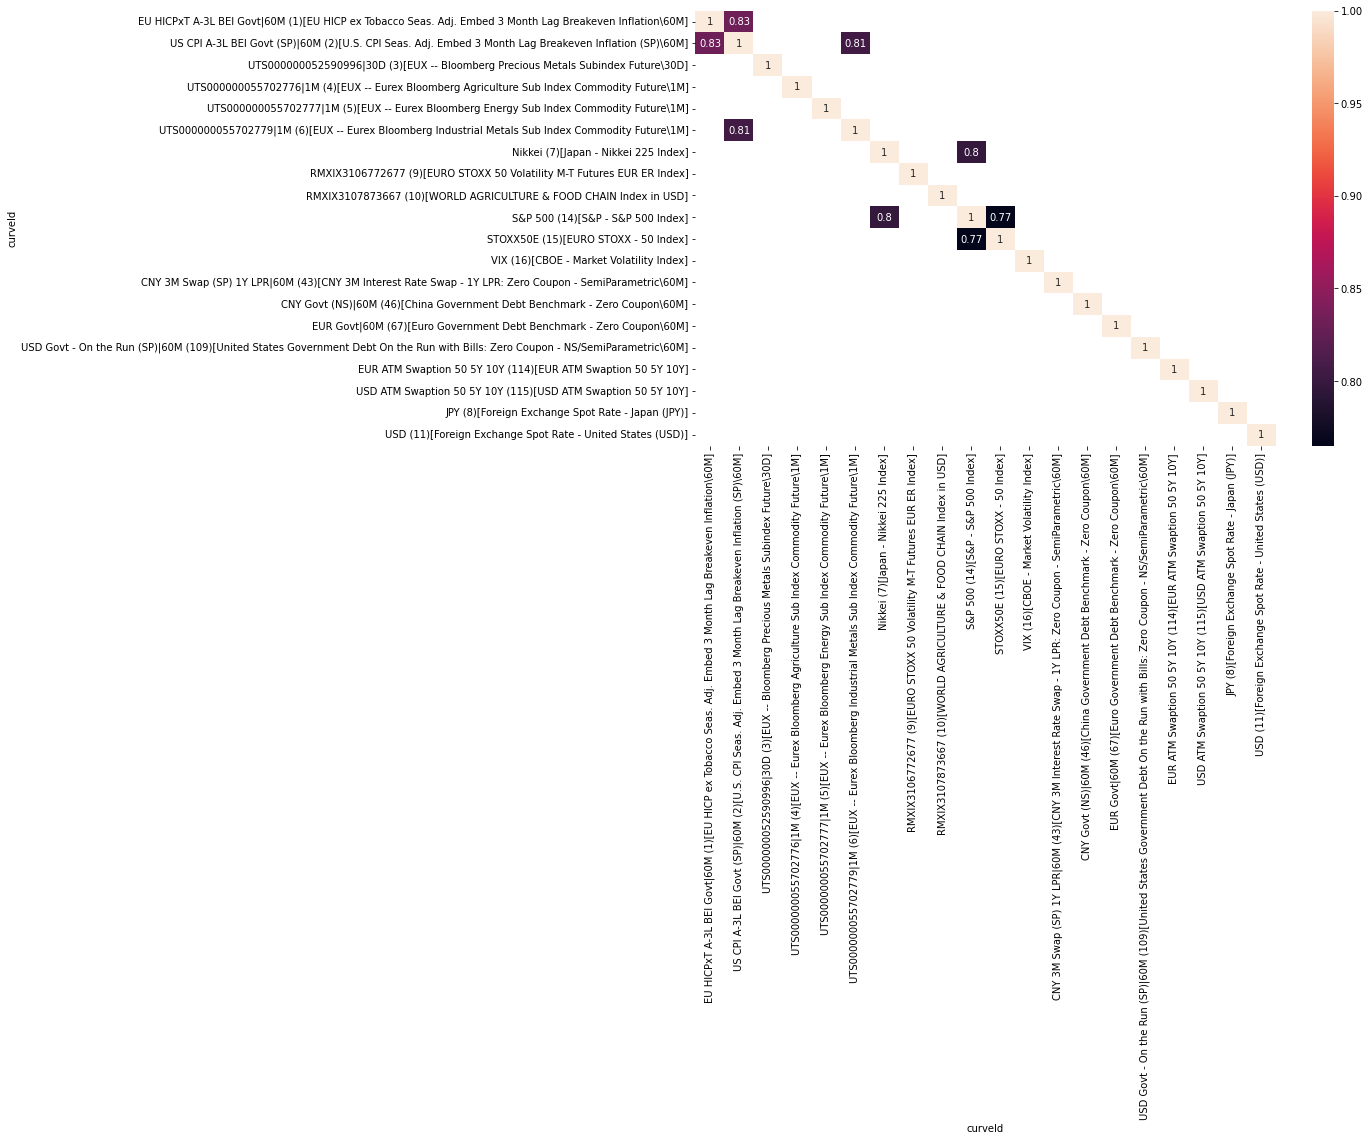

In [8]:
# Check correlation between risk factors
if rem_corr_rf:
    
    rf_to_remove = remove_correlated_risk_factors(df_complete, risk_factors_to_include, corr_threshold,
                                                 rf_to_keep = ['VIX (16)[CBOE - Market Volatility Index]',
                                                              'STOXX50E (15)[EURO STOXX - 50 Index]'])
    risk_factors_to_include_available = list(set(risk_factors_to_include_available).difference(set(rf_to_remove)))
    
    print(str(len(set(rf_to_remove))) + ' risk factors removed due to high correlation: ' + str(set(rf_to_remove)))

In [9]:
# Df with dimension num_curves x num_risk_factors_to_include with correlations between all curves and risk factors
# included in the analysis
if link_metrics in ['corr', 'corr_based_dist']:
    
    df_correlation = compute_ts_correlation(df_complete,
                                           detrend_strategy='diff',
                                           res_index=df_all_lookup_filtered.columns,
                                           res_columns=risk_factors_to_include_available,
                                           return_distance=(link_metrics=='corr_based_dist'))
    
else:
    
    df_correlation = varInfoDf(df_complete, detrend_strategy='diff', norm=True,
                               res_index=df_all_lookup_filtered.columns,
                               res_columns=risk_factors_to_include_available)

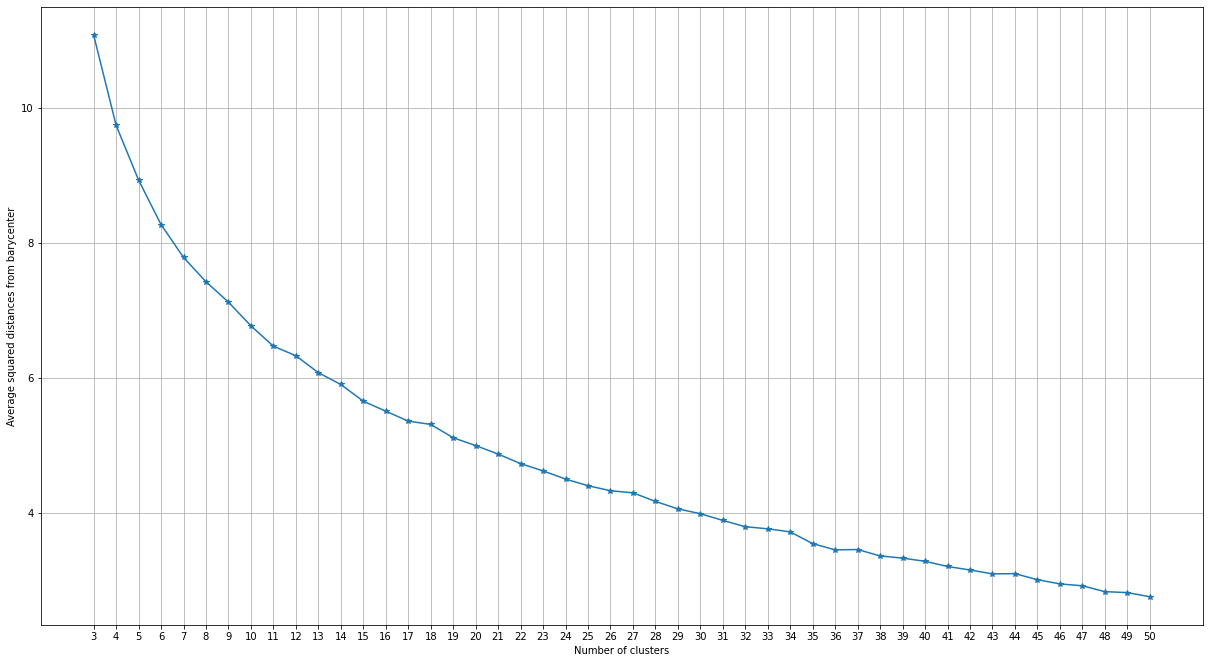

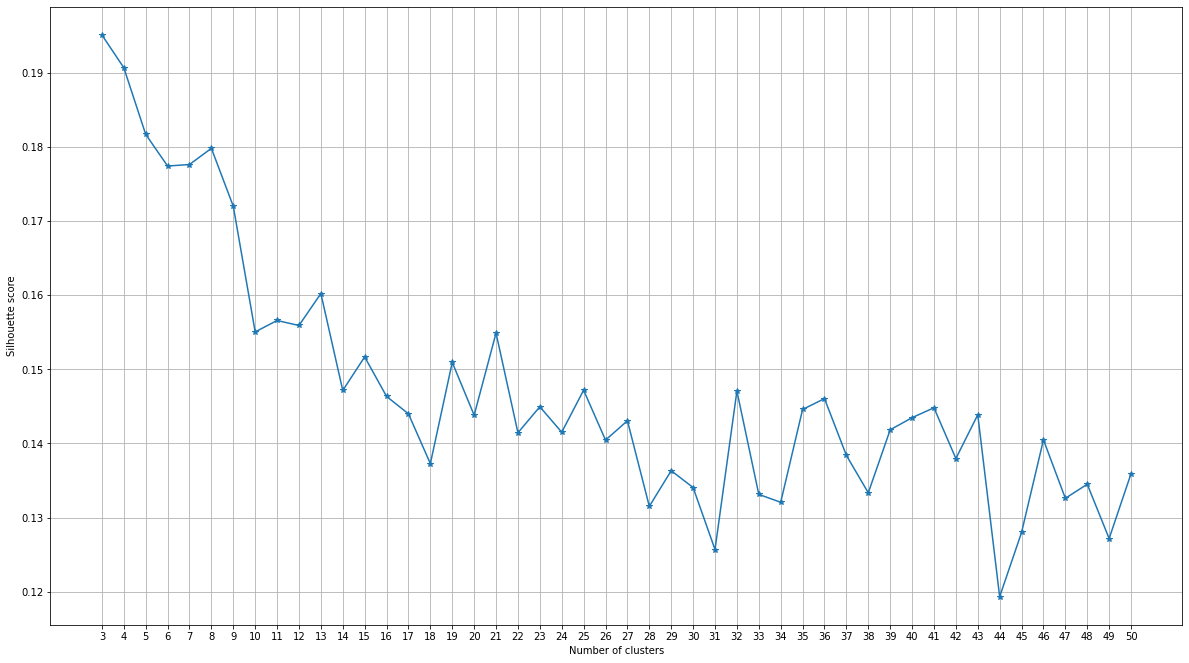

In [10]:
# K-Means clustering with different values of number of clusters

if clustering_algorithm == 'kMeans':
    clustering_results, silhouette, inertia = try_k_means_varying_k(df_correlation, max_num_clusters=max_num_clusters,
                                                                    n_init=10)
    
    # Elbow plot of inertia
    plot_kpi_by_num_clusters(inertia, 'Average squared distances from barycenter')
    
    # Plot of silhouette score
    plot_kpi_by_num_clusters(silhouette, 'Silhouette score')

In [11]:
# Hierarchical clustering

if clustering_algorithm == 'hierarchical':

    hier_clust_fit, linkage = hierarchical_clustering_and_dendrogram(df_correlation,
                                                                    linkage_hierarchical_clustering=hier_clus_linkage)
    
    # Find clustering results for different values of number of clusters from dendrogram
    clustering_results = {}
    for i in range(3, max_num_clusters+1):
        clusters = fcluster(linkage, t=i, criterion='maxclust')
        clustering_results[i] = clusters
        
    # Silhouette scores for the different numbers of clusters
    silhouette_scores = {}
    inertia_scores = {}
    for i in clustering_results:
        sil_score = silhouette_score(df_correlation, clustering_results[i], metric='euclidean')
        silhouette_scores[i] = sil_score
        inertia_scores[i] = compute_inertia(df_correlation, clustering_results[i])
    
    # Plot of insertia
    plot_kpi_by_num_clusters(inertia_scores, 'Average squared distances from barycenter')
    
    # Plot of silhouette score
    plot_kpi_by_num_clusters(silhouette_scores, 'Silhouette score')

## Identify most important risk factors in each cluster

In [12]:
# Specify number of clusters for which you want to see and save results
num_clusters = 7
km_results = clustering_results[num_clusters]

df_results = df_correlation.assign(cluster_label=km_results)

In [13]:
# Specify number of most important risk factors you want to highlight in each cluster
k = 18

top_factors_per_cluster = top_k_rf_per_cluster(df_results, link_metrics, k)

In [14]:
num_pairs = 0
for cl1 in top_factors_per_cluster:
    set_cl1 = set(top_factors_per_cluster[cl1]['factors'])
    for cl2 in top_factors_per_cluster:
        if (set_cl1 == set(top_factors_per_cluster[cl2]['factors'])) and cl1 < cl2:
            print(str(cl1) + ' and ' + str(cl2) + ' have same most important factors')
            num_pairs += 1
print('\n')
print(str(num_pairs) + ' pairs of clusters having same most important risk factors')

5 and 6 have same most important factors
1 and 6 have same most important factors
1 and 5 have same most important factors
1 and 3 have same most important factors
1 and 4 have same most important factors
1 and 2 have same most important factors
0 and 6 have same most important factors
0 and 5 have same most important factors
0 and 1 have same most important factors
0 and 3 have same most important factors
0 and 4 have same most important factors
0 and 2 have same most important factors
3 and 6 have same most important factors
3 and 5 have same most important factors
3 and 4 have same most important factors
4 and 6 have same most important factors
4 and 5 have same most important factors
2 and 6 have same most important factors
2 and 5 have same most important factors
2 and 3 have same most important factors
2 and 4 have same most important factors


21 pairs of clusters having same most important risk factors


In [15]:
# Save output with clustering results
file_name_clustering_results = 'res_clust_1_autoencoder.csv'

df_results = df_correlation.assign(cluster_label=km_results)
df_results = df_results[['cluster_label']]
df_results = pd.DataFrame(df_results).reset_index()
df_results = df_all[['CurveID', 'Perimeter', 'MS_Sector', 'MS_Group']].drop_duplicates().\
    rename(columns={'CurveID': 'curveId'}).\
    merge(df_results)
df_results['MS_Sector'] = np.where(df_results['MS_Sector'] == 'Financial',
                                 'Financials',
                                 df_results['MS_Sector'])
num_clusters = len(df_results['cluster_label'].unique())
df_results['cluster_label'] = np.where(df_results['cluster_label'] == 0,
                                      num_clusters,
                                      df_results['cluster_label'])
df_results.to_csv('../Output/4.1-2_Clustering_Results/' + file_name_clustering_results, sep=';', index=False)

In [16]:
# Save output with most relevant risk factors per each cluster
file_name_important_rf = 'res_clust_1_autoencoder_top_rf.csv'

df_top_rf_result = pd.DataFrame()
for cl in top_factors_per_cluster:
    temp_df = pd.DataFrame(top_factors_per_cluster[cl]).assign(cluster_label = cl)
    df_top_rf_result = pd.concat([df_top_rf_result, temp_df], ignore_index=True)

num_clusters = len(df_top_rf_result['cluster_label'].unique())
df_top_rf_result['cluster_label'] = np.where(df_top_rf_result['cluster_label'] == 0,
                                              num_clusters,
                                              df_top_rf_result['cluster_label'])
df_top_rf_result.to_csv('../Output/4.1-2_Clustering_Results/' + file_name_important_rf, sep=';', index=False)

In [17]:
df_correlation = compute_ts_correlation(df_complete,
                                           detrend_strategy='diff',
                                           res_index=df_all_lookup_filtered.columns,
                                           res_columns=risk_factors_to_include_available,
                                           return_distance=False)

# Specify number of most important risk factors you want to highlight in each cluster
k = 18

# Specify number of clusters for which you want to see and save results
num_clusters = 7
km_results = clustering_results[num_clusters]

df_results = df_correlation.assign(cluster_label=km_results)

top_factors_per_cluster = top_k_rf_per_cluster(df_results, 'corr', k)

df_top_rf_corr = pd.DataFrame()
for cl in top_factors_per_cluster:
    temp_df = pd.DataFrame(top_factors_per_cluster[cl]).assign(cluster_label = cl)
    df_top_rf_corr = pd.concat([df_top_rf_corr, temp_df], ignore_index=True)

num_clusters = len(df_top_rf_corr['cluster_label'].unique())
df_top_rf_corr['cluster_label'] = np.where(df_top_rf_corr['cluster_label'] == 0,
                                              num_clusters,
                                              df_top_rf_corr['cluster_label'])

In [18]:
df_top_rf_result.rename(columns={'avg_corr': 'avg_dist'}).\
    merge(df_top_rf_corr).\
    sort_values(by=['cluster_label', 'avg_dist'], ascending=True).\
    to_csv('../Output/4.1-2_Clustering_Results/' + file_name_important_rf, sep=';', index=False)

In [40]:
df_results.groupby('cluster_label').count()

CurveID  Perimeter  MS_Sector  MS_Group
cluster_label                                         
1                    5          5          5         5
2                   32         32         32        32
3                   55         55         55        55
4                   39         39         39        39
5                   10         10         10        10
6                   82         82         82        82

Number of clusters for silhouette plot: 6
For n_clusters = 6 The average silhouette_score is : 0.25245377710465794


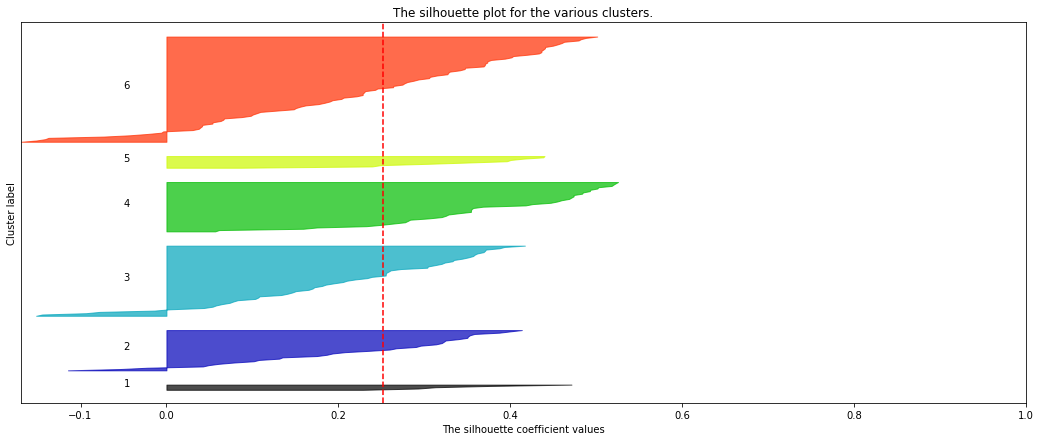

In [41]:
silhouette_plot(df_correlation.values, km_results)